# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
!pip install opencv-python
!pip install wordcloud

In [2]:
!!pip install gTTS

['Requirement already satisfied: gTTS in c:\\programdata\\anaconda3\\lib\\site-packages (2.2.3)',
 'Requirement already satisfied: requests in c:\\programdata\\anaconda3\\lib\\site-packages (from gTTS) (2.24.0)',
 'Requirement already satisfied: click in c:\\programdata\\anaconda3\\lib\\site-packages (from gTTS) (7.1.2)',
 'Requirement already satisfied: six in c:\\programdata\\anaconda3\\lib\\site-packages (from gTTS) (1.15.0)',
 'Requirement already satisfied: certifi>=2017.4.17 in c:\\programdata\\anaconda3\\lib\\site-packages (from requests->gTTS) (2020.6.20)',
 'Requirement already satisfied: chardet<4,>=3.0.2 in c:\\programdata\\anaconda3\\lib\\site-packages (from requests->gTTS) (3.0.4)',
 'Requirement already satisfied: urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1 in c:\\programdata\\anaconda3\\lib\\site-packages (from requests->gTTS) (1.25.11)',
 'Requirement already satisfied: idna<3,>=2.5 in c:\\programdata\\anaconda3\\lib\\site-packages (from requests->gTTS) (2.10)']

In [3]:
#Import all the required libraries
import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

from wordcloud import WordCloud,STOPWORDS

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from PIL import Image

from collections import Counter
import string

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

from collections import Counter
import random
import re
import numpy as np
import pandas as pd
import os
import time
import json
import glob
from pickle import load

from gtts import gTTS
from IPython.display import Audio 

import warnings
warnings.filterwarnings('ignore')

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [4]:
#Import the dataset and read the image into a seperate variable

images= './Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


Some sample images from the dataset with the image name: 



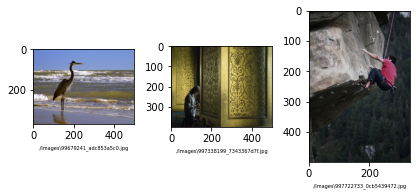

In [5]:
#Visualise both the images & text present in the dataset
i=1
print('Some sample images from the dataset with the image name: \n')
for img in all_imgs[-3:]:
  img1=cv2.imread(img)
  plt.subplot(1, 3, i)
  plt.tight_layout()
  plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
  plt.xlabel(img, fontsize=5)
  i+=1


In [6]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    with open(filename,'r') as f_in:
        text = list(filter(None, (line.rstrip() for line in f_in)))
    f_in.close()

    col=[]
    for line in text:
        col.append(line.split(",",maxsplit=1)) #Maxsplit 1 used to handle the captions with comma

    return col

text_file = './captions.txt'
doc = load_doc(text_file)
print(doc[:300]) 

[['image', 'caption'], ['1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .'], ['1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing into a wooden playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing the stairs to her playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl in a pink dress going into a wooden cabin .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting'], ['1001773457_577c3a7d70.jpg', 'A black dog and a tri-colored dog playing with each other on the road .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a white dog with brown spots are staring at each other in the street .'], ['1001773457_577c3a7d70.jpg', 'Two dogs of different breeds looking at each other on the road .'], ['1001773457_577c3a7d70.jpg', 'Two dogs on pavement moving toward each other .'], ['1002674143_1b742ab4b8.jpg', 'A little girl covere

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
image_path='./Images/'
all_img_id=[]  #store all the image id here
all_img_vector=[] #store all the image path here
annotations= []#store all the captions here

with open('./captions.txt', 'r') as fo:
    next(fo) # to skip the heading 
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
        all_img_vector.append(image_path+split_arr[0])
        
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])

df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,./Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,./Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,./Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,./Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,./Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,./Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,./Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,./Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,./Images/997722733_0cb5439472.jpg,A rock climber in a red shirt


In [8]:
# Data cleaning
# prepare translation table for removing punctuation
remove_punctuation = str.maketrans('', '', string.punctuation)
for i in range(len(annotations)):
    line = annotations[i]
    line = line.split()
    line = [word.lower() for word in line] # convert to lower case
    line = [word.translate(remove_punctuation) for word in line]# remove punctuation from each token
    line = [word for word in line if len(word)>1] # remove hanging 's' and 'a'
    line = [word for word in line if word.isalpha()]# remove tokens with numbers in them
    annotations[i]=  ' '.join(line)   # store as string

In [9]:
#Create a list which contains all the captions
annotations=[i for i in df['Captions']]
print('Example captions from the dataset:\n',annotations[:10], '\n','*'*100)
#print('='*100)

#add the <start> & <end> token to all those captions as well
annotations = ['<start> '+i+' <end>' for i in annotations]
print('Example captions after adding start and end tokens:\n',annotations[:10], '\n','*'*100)

#Create a list which contains all the path to the images
all_img_path=[i for i in df['Path']]
print('Example paths for images:\n',all_img_path[:10], '\n','*'*100)

print("Total captions present in the dataset: \n"+ str(len(annotations)), '\n','*'*100)
print("Total images present in the dataset: \n" + str(len(all_img_path)), '\n','*'*100)

Example captions from the dataset:
 ['A child in a pink dress is climbing up a set of stairs in an entry way ', 'A girl going into a wooden building ', 'A little girl climbing into a wooden playhouse ', 'A little girl climbing the stairs to her playhouse ', 'A little girl in a pink dress going into a wooden cabin ', 'A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road ', 'A black dog and a white dog with brown spots are staring at each other in the street ', 'Two dogs of different breeds looking at each other on the road ', 'Two dogs on pavement moving toward each other '] 
 ****************************************************************************************************
Example captions after adding start and end tokens:
 ['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>', '<start> A girl going into a wooden building  <end>', '<start> A little girl climbing into a wooden playhouse 

In [10]:
#Create the vocabulary & the counter for the captions
from collections import Counter

#vocabulary= #write your code here
vocabulary=[]
for i in df['Captions']:
  for j in i.lower().split():
    vocabulary.append(j)

val_count=Counter(vocabulary)
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

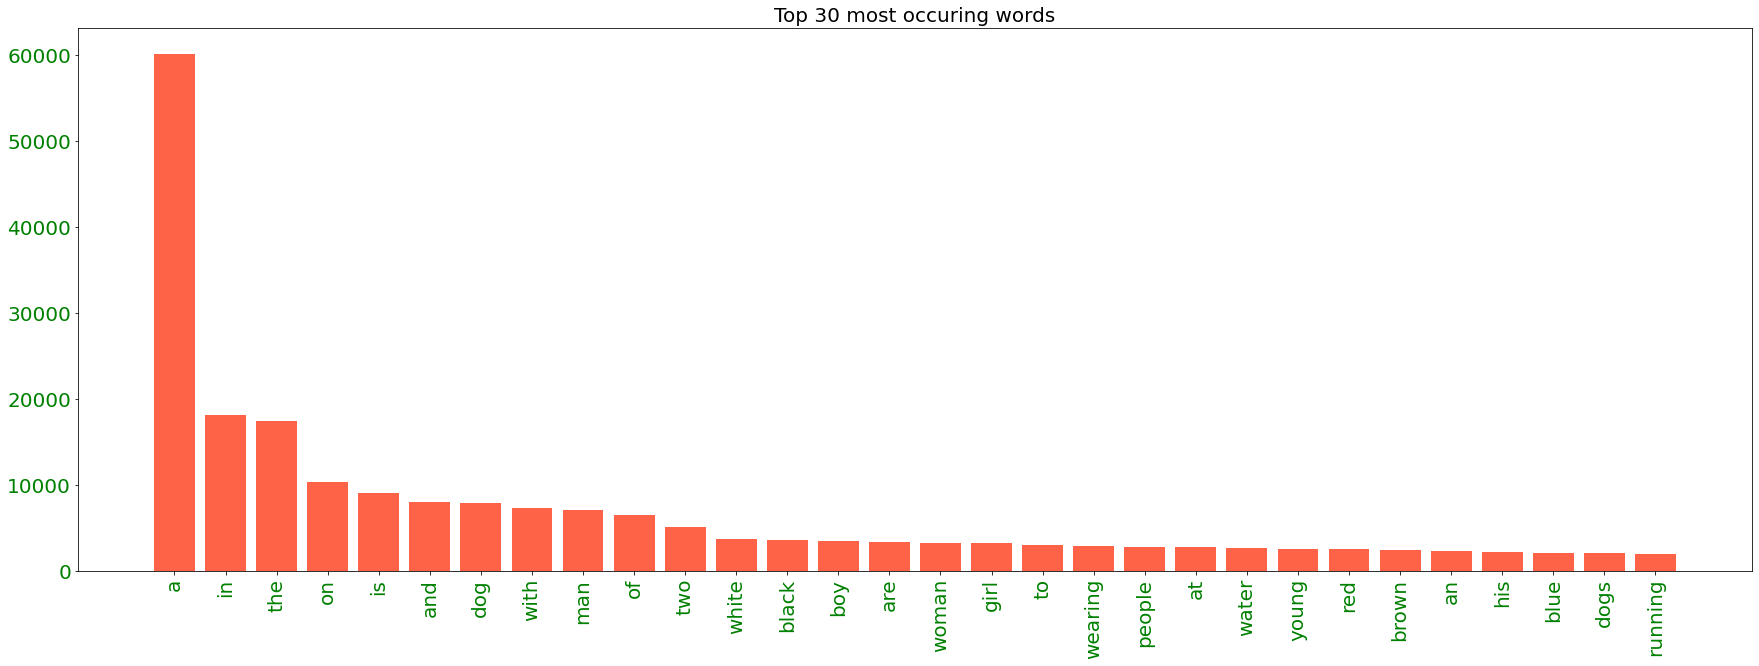

In [11]:
#Visualise the top 30 occuring words in the captions
sorted_tuples = sorted(val_count.items(), key=lambda item: item[1], reverse=True)
sorted_dict = {k: v for k, v in sorted_tuples}

val_count.most_common(30)

top_words = dict(val_count.most_common(30))

plt.figure(figsize=(30,10))

plt.bar(range(len(top_words)), list(top_words.values()), align='center', color='tomato')
plt.xticks(range(len(top_words)), list(top_words.keys()),rotation=90, fontsize=20,color = 'green')
plt.yticks(fontsize=20,color ='green')
plt.title("Top 30 most occuring words",fontsize=20)

plt.show()

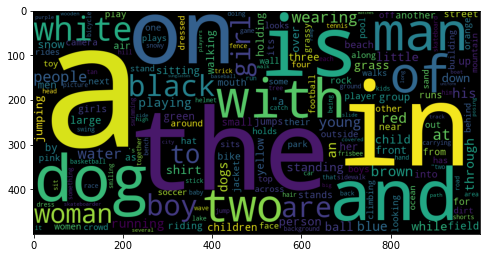

In [12]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

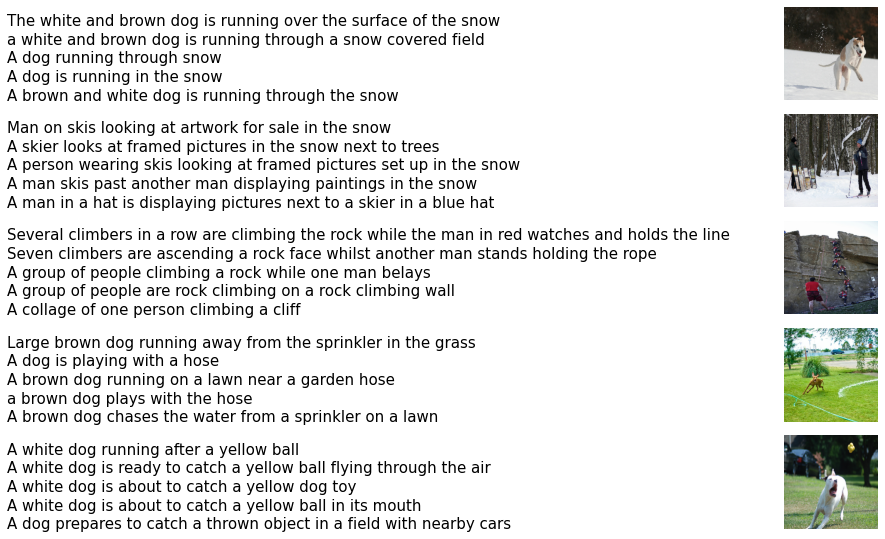

In [13]:
from keras.preprocessing.image import load_img

fig = plt.figure(figsize=(15,15)) # For dosplaying image
count = 1
    
for Path in df[50:75].Path.unique(): # Loading 1st 25 paths which will have 5 distinct images
    captions = list(df["Captions"].loc[df.Path== Path].values)
    display_image = load_img(Path,target_size=(299,299,3))
    ax = fig.add_subplot(10,2,count) #Adding a subplot that spans 5 rows:
    plt.axis('off')  # we don't want both x and y axes for caption 
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions)) #to decide the spacing between each line of caption
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)  #to display the captions         
    count+=1
    plt.tight_layout() #to make sure that image and caption don't overlap

    ax = fig.add_subplot(10,2,count)
    ax.imshow(display_image)
    plt.axis('off')
    count +=1

plt.show()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [14]:
# Create word-to-index and index-to-word mappings.
top_voc = 5000
tokenizer =tf.keras.preprocessing.text.Tokenizer(num_words=top_voc+1,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                                  lower=True, char_level=False,
                                                  oov_token="UNK")


# Create word-to-index and index-to-word mappings.

tokenizer.fit_on_texts(annotations) #Updates internal vocabulary based on a list of texts.

train_seqs = tokenizer.texts_to_sequences(annotations)#Transforms each text in texts to a sequence of integers.

# when we use the pad_sequence to process the sequence, we will be using 0 as the padding value.
# In order to distinguish between PAD and UNKNOWN, keras use different index for UNKNOWN.

# 0 is a reserved index that won't be assigned to any word.Let's add PAD token for zero

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

<start> :  40455
<end> :  40455
a :  38716
A :  21480
in :  18170
the :  14587
on :  10354
is :  9069
and :  8057
dog :  7804
with :  7303
man :  6727
of :  6495
Two :  3962
white :  3646
black :  3491
boy :  3395
are :  3364
girl :  3174
woman :  3146
to :  3005
The :  2919
wearing :  2916
at :  2809
water :  2671
red :  2542
young :  2411
people :  2397
brown :  2383
his :  2255


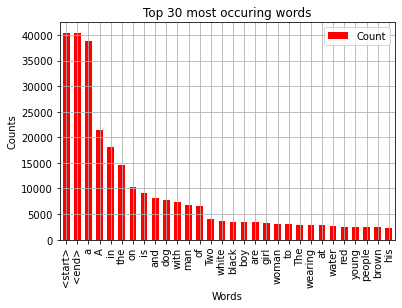

In [15]:
import collections

# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
tokenizer_top_words= [word for line in annotations for word in line.split()]

tokenizer_top_words_count=collections.Counter(tokenizer_top_words)
tokenizer_top_words_count

for word, count in tokenizer_top_words_count.most_common(30):
    print(word, ": ", count)

token_lst = tokenizer_top_words_count.most_common(30)
most_common_words_df = pd.DataFrame(token_lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.grid(b=None)

In [110]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
train_seqs_len=[len(seq) for seq in train_seqs] #storing all lengths in list.Can be used if needed in future
longest_word_length= max(train_seqs_len) #Python list method max returns the elements from the list with maximum value.

# Calculates the longest_word_length to pad all sequences to be the same length as the longest one.

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=longest_word_length,
                                                          dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))


The shape of Caption vector is :(40455, 35)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [17]:
#write your code here to create the dataset consisting of image paths
tf.keras.backend.image_data_format()

IMAGE_SHAPE= (299, 299)

In [18]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    #write your pre-processing steps here
    img = tf.io.read_file(image_path,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.decode_jpeg(img,channels=0) 
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    return img, image_path
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)


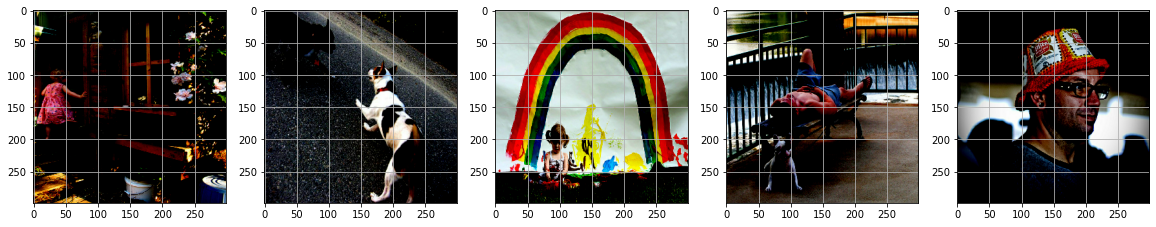

In [19]:
preprocessed_img=[]
for img in all_imgs[0:5]:
    img = tf.io.read_file(img,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    img = tf.image.decode_jpeg(img,channels=0) #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None)#Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    preprocessed_img.append(img)

Display_Images= preprocessed_img[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    print("Shape after resize :", image.shape)
    ax.imshow(image)
    ax.grid('off')

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [20]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

#image_features_extract_model = keras.Model(new_input, hidden_layer) #build the final model using both input & output layer
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)  #build the final model using both input & output layer

In [81]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
image_features_extract_model.summary()
# write your code to extract features from each image in the dataset
# sorting and storing unique path in list which will be given as input 
training_list = sorted(set(all_img_vector)) 

# Creating a Dataset using tf.data.Dataset.from_tensor_slice
New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)


# Mappng load_image across the elements of the above dataset.
# num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
New_Image_Data = New_Image_Data.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


# Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
# We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
New_Image_Data= New_Image_Data.batch(64,drop_remainder=False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [22]:
image_features_dict={}
for image, image_path in tqdm(New_Image_Data): #using tqdm as progress bar
    features_for_batch = image_features_extract_model(image) #feeding images from above created dataset to Inception v3 which we build above
    #fb_shape = features_for_batch.get_shape().as_list()
    #features_for_batch_flattened = tf.contrib.layers.flatten(fb_shape) 
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3])) ##We are sqeezing/squashing 
                                   
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [09:00<00:00,  4.25s/it]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [23]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [24]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [25]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image,captions):# your input variable goes here):
  img_tensor = image_features_dict[image.decode('utf-8')]# write your code here to extract the features from the dictionary stored earlier
  return img_tensor,captions

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [26]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000

# Batch size
BATCH_SIZE = 64

def gen_dataset(images_data, captions_data):#your input variables):
   
    # Creating a Dataset using tf.data.Dataset.from_tensor_slice 
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))

    # num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # reshuffle_each_iteration=True indicate Shuffle order should be different for each epoch.
    # Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
    # We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
    # Prefetch function is used to prepare later elements while the current element is being processed.
    
    dataset = (
     dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True) 
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    ) 

    return dataset


In [27]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [28]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [29]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE  #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE   #len(total test images) // BATCH_SIZE
max_length=31
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

### Encoder

In [30]:
tf.compat.v1.reset_default_graph() #to resolve compatibility issue
#from tensorflow.python.framework import ops
#ops.reset_default_graph()
#tf.compat.v1.GraphDef()

In [31]:
print(tf.compat.v1.get_default_graph())

In [32]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build your Dense layer with relu activation
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0) #applying relu activation 
        return features

In [33]:
encoder=Encoder(embedding_dim)

### Attention model

In [34]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis=hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        # the tensor is reduced along the second dimension (columns)

        return context_vector, attention_weights

### Decoder

In [35]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [36]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [37]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [38]:
optimizer =tf.keras.optimizers.Adam(lr=0.001) #define the optimizer
loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE) #define your loss object

In [39]:
# zero is causing discrepency.we dont want decoder to give importance to zero.so lets mask zero to false

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # we are multiplying loss with mask to get ideal shape

    return tf.reduce_mean(loss_)

In [40]:
checkpoint_path = "./Images/checkpoint"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [41]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [42]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation for implementing backpropagation
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions)

          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [43]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions) 

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))
        
    return loss, avg_loss

In [46]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [47]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.058, & test loss is 1.032
Time taken for 1 epoch 1176.2592933177948 sec

Test loss has been reduced from 100.000 to 1.032


  7%|█████▎                                                                         | 1/15 [19:36<4:34:31, 1176.57s/it]

For epoch: 2, the train loss is 0.951, & test loss is 0.934
Time taken for 1 epoch 1142.5436499118805 sec

Test loss has been reduced from 1.032 to 0.934


 13%|██████████▌                                                                    | 2/15 [38:39<4:12:43, 1166.46s/it]

For epoch: 3, the train loss is 0.881, & test loss is 0.867
Time taken for 1 epoch 1188.4960985183716 sec

Test loss has been reduced from 0.934 to 0.867


 20%|███████████████▊                                                               | 3/15 [58:28<3:54:37, 1173.15s/it]

For epoch: 4, the train loss is 0.824, & test loss is 0.811
Time taken for 1 epoch 1175.102459192276 sec

Test loss has been reduced from 0.867 to 0.811


 27%|████████████████████▌                                                        | 4/15 [1:18:03<3:35:12, 1173.84s/it]

For epoch: 5, the train loss is 0.775, & test loss is 0.764
Time taken for 1 epoch 1178.5448744297028 sec

Test loss has been reduced from 0.811 to 0.764


 33%|█████████████████████████▋                                                   | 5/15 [1:37:42<3:15:53, 1175.34s/it]

For epoch: 6, the train loss is 0.730, & test loss is 0.718
Time taken for 1 epoch 1182.7307677268982 sec

Test loss has been reduced from 0.764 to 0.718


 40%|██████████████████████████████▊                                              | 6/15 [1:57:25<2:56:38, 1177.65s/it]

For epoch: 7, the train loss is 0.688, & test loss is 0.679
Time taken for 1 epoch 1200.5080962181091 sec

Test loss has been reduced from 0.718 to 0.679


 47%|███████████████████████████████████▉                                         | 7/15 [2:17:26<2:37:56, 1184.58s/it]

For epoch: 8, the train loss is 0.650, & test loss is 0.640
Time taken for 1 epoch 1194.4522244930267 sec

Test loss has been reduced from 0.679 to 0.640


 53%|█████████████████████████████████████████                                    | 8/15 [2:37:21<2:18:33, 1187.63s/it]

For epoch: 9, the train loss is 0.614, & test loss is 0.605
Time taken for 1 epoch 1219.4793918132782 sec

Test loss has been reduced from 0.640 to 0.605


 60%|██████████████████████████████████████████████▏                              | 9/15 [2:57:40<1:59:43, 1197.27s/it]

For epoch: 10, the train loss is 0.581, & test loss is 0.574
Time taken for 1 epoch 1212.2365663051605 sec

Test loss has been reduced from 0.605 to 0.574


 67%|██████████████████████████████████████████████████▋                         | 10/15 [3:17:53<1:40:09, 1201.85s/it]

For epoch: 11, the train loss is 0.550, & test loss is 0.545
Time taken for 1 epoch 1214.0605750083923 sec

Test loss has been reduced from 0.574 to 0.545


 73%|███████████████████████████████████████████████████████▋                    | 11/15 [3:38:07<1:20:22, 1205.59s/it]

For epoch: 12, the train loss is 0.521, & test loss is 0.521
Time taken for 1 epoch 1221.046953201294 sec

Test loss has been reduced from 0.545 to 0.521


 80%|████████████████████████████████████████████████████████████▊               | 12/15 [3:58:29<1:00:30, 1210.32s/it]

For epoch: 13, the train loss is 0.494, & test loss is 0.494
Time taken for 1 epoch 1221.1734352111816 sec

Test loss has been reduced from 0.521 to 0.494


 87%|███████████████████████████████████████████████████████████████████▌          | 13/15 [4:18:50<40:27, 1213.66s/it]

For epoch: 14, the train loss is 0.471, & test loss is 0.471
Time taken for 1 epoch 1235.921110868454 sec

Test loss has been reduced from 0.494 to 0.471


 93%|████████████████████████████████████████████████████████████████████████▊     | 14/15 [4:39:26<20:20, 1220.41s/it]

For epoch: 15, the train loss is 0.449, & test loss is 0.450
Time taken for 1 epoch 1243.0631141662598 sec

Test loss has been reduced from 0.471 to 0.450


100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [5:00:09<00:00, 1200.66s/it]


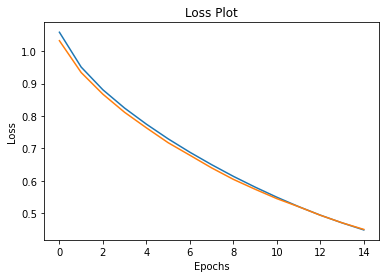

In [48]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [82]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =  tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [117]:
def beam_evaluate(image, beam_index=3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]
    
    attention_plot = np.zeros((longest_word_length, attention_features_shape))
    
    hidden = decoder.init_state(batch_size=1)
    
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    while len(result[0][0]) < longest_word_length:
        temp = []
        i = 0
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i = i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]

            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(predictions[0][w])
                temp.append([next_cap, prob])
                    
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]
    
        predicted_id = result[-1]
        pred_list = predicted_id[0]
       
        prd_id = pred_list[-1] 
         
        if(prd_id!=4):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
        
    result = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result]
    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break

    attention_plot = attention_plot[:len(final_caption), :]
    #final_caption = ' '.join(final_caption[1:])
    return final_caption,attention_plot



In [114]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [52]:
from nltk.translate.bleu_score import sentence_bleu

In [53]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: {7.973301625706313e-153}
Real Caption: a boy surfs
Prediction Caption:a barechested man surfs on a surfboard


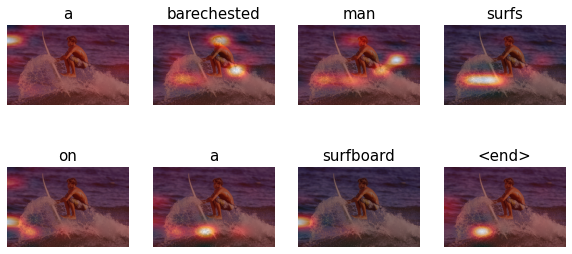

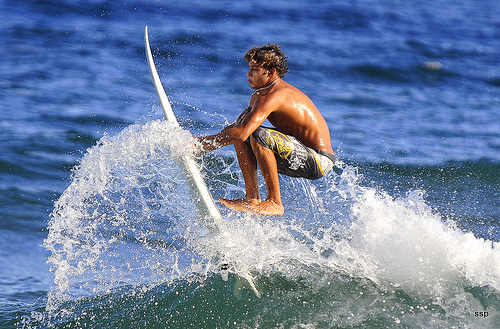

In [146]:
weights = (0.5,0.5,0,0)
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=weights)#set your weights)
print("BELU score:", {score*100})

print('Real Caption:', real_caption)
print('Prediction Caption:'+ pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

##### Here we can see in the above image that the prediction gives better caption than the one in the captions file. These cases are rare though.
BELU score: {7.973301625706313e-153}
Real Caption: a boy surfs
Prediction Caption:a barechested man surfs on a surfboard


In [147]:
# Passing the text and language to the engine, 
myobj = gTTS(text=pred_caption, lang=language, slow=False)
  
# Saving the converted audio in a mp3 file named
myobj.save("Predicted_text.mp3")
  
# Playing the converted file
os.system("./Predicted_text.mp3")

1

In [148]:
captions=beam_evaluate(test_image)
print(captions)

(['<start>', 'a', 'surfer', 'man', 'surfs'], array([[2.80347434e-09, 1.78567006e-03, 1.75113692e-05, 5.52370203e-08,
        7.65524710e-09, 3.35891119e-13, 4.26475424e-13, 2.35921916e-12,
        1.24860695e-03, 1.14768958e-02, 1.31805316e-02, 3.50515766e-04,
        2.05237811e-04, 5.58503438e-03, 1.45596459e-08, 2.63370818e-11,
        4.43150711e-05, 1.00296911e-05, 3.49588686e-06, 3.03416391e-06,
        2.71568069e-06, 1.14890126e-05, 6.29857033e-02, 6.01514921e-06,
        7.42475837e-02, 2.53468570e-05, 2.65917538e-06, 3.41408418e-06,
        3.51222116e-06, 3.18795060e-06, 2.33956682e-03, 4.13794070e-03,
        9.07354131e-02, 1.54622794e-05, 4.01088391e-06, 7.67476286e-06,
        1.74085981e-05, 8.53462479e-05, 1.28976209e-02, 3.05091497e-04,
        2.11146399e-02, 1.06253673e-03, 3.22164648e-04, 2.91823031e-04,
        4.96955495e-03, 1.16690211e-02, 2.02768780e-02, 4.29981956e-05,
        5.08205311e-10, 9.35803130e-02, 5.24275839e-01, 2.98684482e-02,
        8.82027205e